## Test the repo output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

In [ ]:
# # plt.imshow()
# !pip install flow_vis

In [ ]:
import numpy as np
flow_file = '/home/yoyee/Documents/deep_keyframe/pytorch-pwc/flow.out.npy'
flow = np.load(flow_file)

In [ ]:

flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=False)

In [ ]:
flow_color.shape

In [ ]:

plt.imshow(flow_color)
plt.show()

## Test pwcNet

In [3]:
import numpy as np
from pwcNet import estimate, estimate_batch
import torch
import PIL
import PIL.Image

In [6]:
dummy_im = np.ones((120,160,3))
first_file = './images/first.png'
second_file = './images/second.png'
first_im = np.array(PIL.Image.open(first_file))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
second_im = np.array(PIL.Image.open(second_file))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
# tenFirst = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
tenFirst = torch.FloatTensor(first_im)
# tenSecond = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
tenSecond = torch.FloatTensor(second_im)
flow = estimate(tenFirst, tenSecond)

In [7]:
# estimate_batch
device = 'cuda'
flow = estimate_batch(tenFirst.unsqueeze(0).to(device), tenSecond.unsqueeze(0).to(device))
print(flow.shape)
flow = flow.to('cpu').squeeze(0).numpy().transpose([1,2,0])
print(flow.shape)

tenPreprocessedFirst: torch.Size([1, 3, 448, 1024])
torch.Size([1, 2, 436, 1024])
(436, 1024, 2)


In [21]:
# estimate_batch repetitive images
batch = 2
first_im = np.array(PIL.Image.open(first_file)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
tenFirst = torch.FloatTensor(first_im)
tenFirst = torch.stack([tenFirst]*batch)
second_im = np.array(PIL.Image.open(second_file)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
tenSecond = torch.FloatTensor(second_im)
tenSecond = torch.stack([tenSecond]*batch)
print(f"tenFirst: {tenFirst.shape}")

flow = estimate_batch(tenFirst.to(device), tenSecond.to(device))
flow = flow.to('cpu').numpy().transpose([0,2,3,1])
print(flow.shape)

tenFirst: torch.Size([2, 3, 436, 1024])
tenPreprocessedFirst: torch.Size([2, 3, 448, 1024])
(2, 436, 1024, 2)


In [ ]:
for i, f in enumerate(flow):
    flow_color = flow_vis.flow_to_color(flow[i], convert_to_bgr=False)
    plt.imshow(flow_color)
    plt.show()

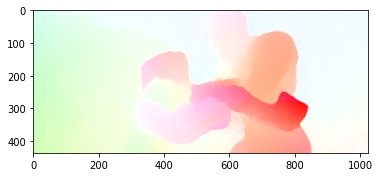

In [31]:
flow_color = flow_vis.flow_to_color(flow[0], convert_to_bgr=False)
plt.imshow(flow_color)
plt.show()

## test matching

In [22]:

def flow2match(flow):
    def meshgrid(h, w):
        xx, yy = np.meshgrid(np.arange(0,w), np.arange(0,h))
        meshgrid = np.transpose(np.stack([xx,yy], axis=-1), [2,0,1]) # [2,h,w]
        meshgrid = torch.from_numpy(meshgrid)
        return meshgrid

    batch_size, img_h, img_w = flow.shape[0], flow.shape[2], flow.shape[3]
        
    # fwd_flow, bwd_flow, img1_valid_mask, img2_valid_mask, img1_flow_diff_mask, img2_flow_diff_mask = self.model_flow.inference_corres(img1, img2)
    fwd_flow = flow
    grid = meshgrid(img_h, img_w).float().to(flow.get_device()).unsqueeze(0).repeat(batch_size,1,1,1) #[b,2,h,w]
    corres = torch.cat([(grid[:,0,:,:] + fwd_flow[:,0,:,:]).clamp(0,img_w-1.0).unsqueeze(1), \
        (grid[:,1,:,:] + fwd_flow[:,1,:,:]).clamp(0,img_h-1.0).unsqueeze(1)], 1)
    match = torch.cat([grid, corres], 1) # [b,4,h,w]
    return match

In [23]:
flow = estimate_batch(tenFirst.to(device), tenSecond.to(device))
match = flow2match(flow)

tenPreprocessedFirst: torch.Size([2, 3, 448, 1024])


In [24]:
match.shape

torch.Size([2, 4, 436, 1024])

In [25]:
match[0,:,100,100]

tensor([100.0000, 100.0000,  95.6183, 103.0982], device='cuda:0')

In [26]:
flow[0,:,100,100]

tensor([-4.3817,  3.0982], device='cuda:0')